In [1]:
%matplotlib widget

In [2]:
import glob
import os.path
import numpy as np
from astropy.io import fits

from image_plane_correction.flow import Flow
from image_plane_correction.catalogs import theoretical_sky
from image_plane_correction.preprocessing import normalize, normalize_high, preprocess
from image_plane_correction.util import indices, rescale_quantile, gaussian_filter, circular_mask
from image_plane_correction import data
from image_plane_correction.interactive import plot_flow, plot_image, toggle_images

In [3]:
image_fns = sorted(glob.glob('/lustre/gh/main/10h/2024-12-18/Run_Rescue_20260205_060823/55MHz/snapshots/55MHz*I-image.fits'))
psf_fns = sorted(glob.glob('/lustre/gh/main/10h/2024-12-18/Run_Rescue_20260205_060823/55MHz/snapshots/55MHz*-psf.fits'))

In [4]:
assert len(image_fns) == len(psf_fns)

In [5]:
def calcflow(ind, qa=True, write=False):
    print(f'Processing {os.path.basename(image_fns[ind])}')
    image, imwcs = data.fits_image(image_fns[ind])
    psf, psfwcs = data.fits_image(psf_fns[ind])

    # Calculate model sky, preprocess, and run flow
    sky = theoretical_sky(imwcs, psf, catalog="VLSSR", max_flux=20, path='/home/claw/vlssr_radecpeak.txt')
    image_processed, sky_processed = preprocess(image, sky, weight=1.5)
    flow = Flow.brox(image_processed, sky_processed, alpha=1.3, gamma=150, scale_factor=0.7)
    dewarped = flow.apply(image)

    if qa:
        score = runqa(image, sky, flow, dewarped)
    else:
        score = 1  # pass

    if write:
        if qa and score == 1:
            outname = image_fns[ind].replace('.fits', '_dewarp.fits')
            dewarped_arr = np.array(dewarped)
            fits.writeto(outname, dewarped_arr, imwcs.to_header())
        else:
            print(f'image {image_fns[ind]} failed qa. Not writing dewarped image.')

    return image, sky, flow, dewarped

def runqa(image, sky, flow, dewarped):
    offsets = np.nan_to_num(flow.offsets)
    if not offsets.any():
        print("Warning: All offsets zero")

    shift_mag = np.linalg.norm(offsets, axis=2)
    shift_mean = np.mean(shift_mag)
    shift_5, shift_median, shift_95 = np.percentile(shift_mag, [5, 50, 95])
    print(f"Shift magnitude mean {shift_mean:.1f} pix (5, 50, 95 percentiles: {shift_5:.1f}, {shift_median:.1f}, {shift_95:.1f} pix)")

    if sky is not None:
        pcts = [5, 32, 50, 68, 95]
        residuals = np.abs(np.percentile(dewarped-sky, pcts)) - np.abs(np.percentile(image-sky, pcts))
        if not all(residuals < 0):
            print(f"Not all residuals improved. (Percentile, residual difference): {list(zip(pcts, residuals.tolist()))}")
            score = 0
        else:
            score = 1

    return score

In [8]:
offsets_list = []
for i in range(0, len(image_fns), 10):
    image, sky, flow, dewarped = calcflow(i, write=False, qa=False)
    offsets_list.append(np.nan_to_num(flow.offsets))

Processing 55MHz-Pilot-Snapshot-20241218_120247-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_120427-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_120607-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_120747-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_120927-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_121107-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_121247-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_121427-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_121607-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_121747-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_121927-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_122107-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_122247-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_122427-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_122607-I-image.fits
Processing 55MHz-Pilot-Snapshot-20241218_122747-I-image.fits
Processing 55MHz-Pilot-S

In [9]:
offsets_arr = np.array(offsets_list)

In [10]:
offset_mean_vec = offsets_arr.mean(axis=0)

In [11]:
offset_mean_mean_amp = np.linalg.norm(offset_mean_vec, axis=2).mean()

In [35]:
offset_mean_mean_amp

np.float32(2.5344977)

In [33]:
diff_offset_mean_amp = np.median(np.linalg.norm(offsets_arr - offset_mean_vec, axis=3), axis=(1,2))

In [34]:
diff_offset_mean_amp

array([0.96849215, 0.48988003, 0.5660551 , 0.8647752 , 0.636145  ,
       0.914987  , 1.0076561 , 0.7302223 , 0.58031577, 4.9990444 ,
       0.63997597, 0.6717262 , 0.4721893 , 0.50391626, 0.66864747,
       0.63076246, 0.54958534, 0.55831975, 0.9702284 , 0.45447278,
       0.8085692 , 0.7960418 , 1.1509714 , 1.0436783 , 0.75872964,
       0.87666106, 1.1907573 , 0.7542771 , 1.1061001 , 0.41504824,
       0.5348183 , 0.7524151 , 0.6587377 , 3.0404277 , 1.3978274 ,
       0.9293623 ], dtype=float32)

In [16]:
amps = np.linalg.norm(offsets_arr, axis=3)

In [18]:
import matplotlib.pyplot as plt

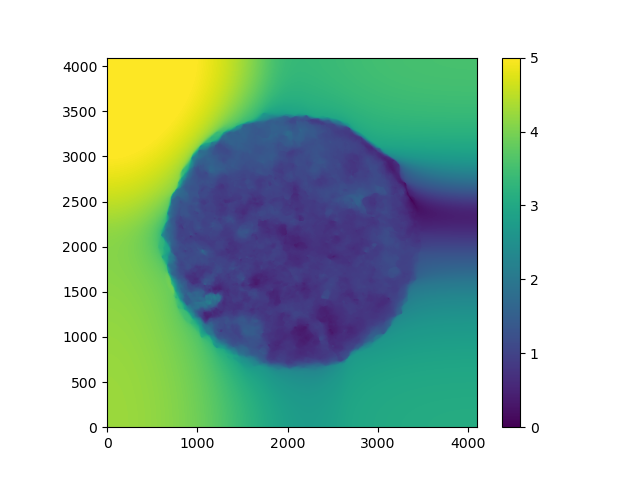

In [31]:
plot_image(np.linalg.norm(offset_mean_vec, axis=2), vmin=0, vmax=5)

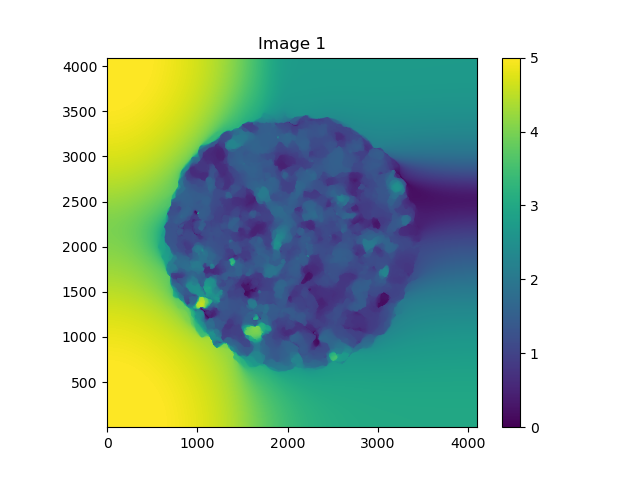

In [32]:
toggle_images(*amps[-4:-2], vmax=5)

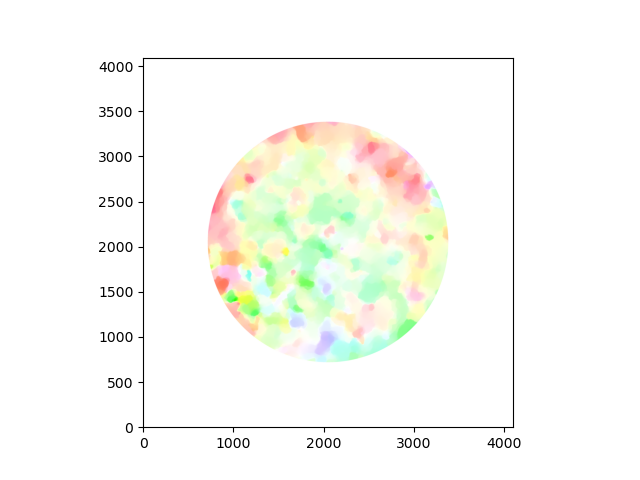

In [93]:
plot_flow(flow, mask=circular_mask(r=0.65))

In [94]:
dewarped = flow.apply(image)

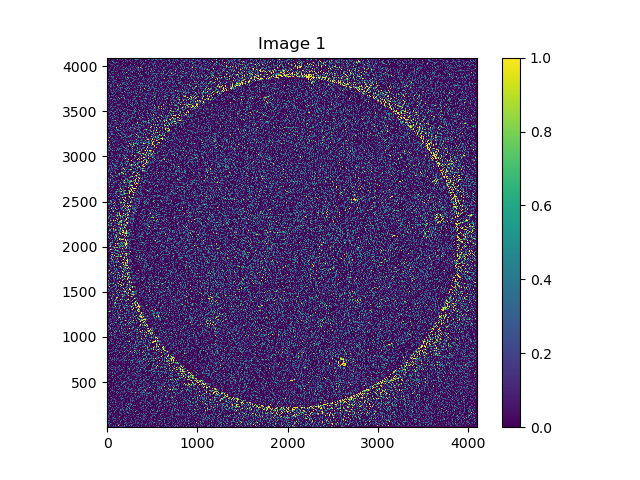

In [95]:
toggle_images(normalize_high(sky-dewarped), normalize_high(sky))